In [1]:
%matplotlib inline
import pandas as pd

#### Append the two data sets

In [2]:
df1 = pd.read_csv('ss13husa.csv')
df2 = pd.read_csv('ss13husb.csv')
df = df1.append(df2)

### Check that the lengths of the datasets

#### See how many columns are in the dataset

#### Preliminary Feature Selection

#### Extract features that relate to hving internet

In [3]:
internet_features = ['DIALUP','DSL', 'FIBEROP', 'MODEM', 'OTHSVCEX', 'SATELLITE']

In [4]:
# Condition which represents having some form of internet service
dsl_true = df['DSL'] == 1
dialup_true = df['DIALUP'] == 1
satellite_true = df['SATELLITE'] == 1
other_true = df['OTHSVCEX'] == 1
modem_true = df['MODEM'] == 1
fiber_true = df['FIBEROP'] == 1
internet_true = dsl_true | dialup_true | satellite_true | other_true | modem_true | fiber_true
# Condition which represent having no form of internet service
dsl_false = df['DSL'] == 2
dialup_false = df['DIALUP'] == 2
satellite_false = df['SATELLITE'] == 2
other_false = df['OTHSVCEX'] == 2
modem_false = df['MODEM'] == 2
fiber_false = df['FIBEROP'] == 2
internet_false = dsl_false & dialup_false & satellite_false & other_false & modem_false & fiber_false



In [5]:
df['INTERNET'] = 1
df['INTERNET'] = df['INTERNET'].where(internet_true, other = 0)

In [6]:

features = [#'RT',          # Record Type
 #'SERIALNO',    # Housing Unit Serial No.
 #'DIVISION',    # Division Code
 #'PUMA',        # Public Use Microdata Area Code
 'REGION',      # Region
 'ST',          # State Code
 #'ADJHSG',     # Adjustment factor for Housing
 #'ADJINC',     # Inflation adjustment for Income
 #'WGTP',       # Housing Weight
 'NP',          # Number of person records following this household
 'TYPE',        # Type of Unit 

 #'ACR',         # Lot Size
 #'AGS',        # Sales of Agriculture Products
 'BATH',        # Bathtub or Shower
 'BDSP',        # Number of bedrooms
 'BLD',         # Units in Structure
 'BROADBND',    # Mobile Broadband Plan
 #'BUS',         # Business or medical office on property
 #'COMPOTHX',   # Other computer equipment
 #'CONP',       # Condo Fee

 #'ELEP',       # Electricity Monthly Cost

 'FS',          # Yearly Food Stamp Recipiency
 #'FULP',       # Fuel Cost (other than gas and elec)
 #'GASP',       # Monthly Gas Cost
 'HANDHELD',    # Handheld Computer
 #'HFL',        # House Heating Fuel
 #'INSP',       # Fire/Hazard/Flood Insurance
 'LAPTOP',      # Laptop?
 #'MHP',        # Mobile Home Costs

 #'MRGI',       # First Mortgage includes fire/hazard/flood insurance
 #'MRGP',       # First Mortgage Payment
 #'MRGT',       # First Mortgage Payment includes real estate taxes
 #'MRGX',       # First Mortgage Status

 #'REFR',       # Refridgerator
 'RMSP',        # Number of Rooms
 #'RNTM',        # Meals included in rent
 #'RNTP',        # Monthly Rent
 #'RWAT',       # Hot and Cold Water Running
 #'RWATPR',     # Running Water

 'SINK',        # Sink with a Faucet
 #'SMP',        # Total payment on all second and junior mortgages
 'STOV',        # Stove or Range
 'TEL',         # Telephone
 'TEN',         # Tenure
 #'TOIL',       # Flush Toilet
 #'VACS',        # Vacancy Status
 #'VALP',        # Property Value
 #'VEH',        # Vehicles Available
 #'WATP',       # Water Yearly Cost
 'YBL',         # When Structure first built
 #'FES',         # Family Type and Employment Status
 #'FFINCP',      # Family income allocation flag      
 #'FGRNTP',      # Yearly food stamp allocation flag
 #'FHINCP',      # Household income allocation flag
 #'FINCP',       # Family Income
 #'FPARC',       # Family presence and age of related children
 #'FSMOCP',      # Selected monthly owner cost allocation flag
 #'GRNTP',       # Gross Rent
 #'GRPIP',       # Gross rent as a percentage of household income
 'HHL',         # Household Language
 'HHT',         # Household/family Type
 'HINCP',       # Household income (past 12 months)
 'HUGCL',       # Household w/ grandparent living w/ grandchildren
 'HUPAC',       # Children Present
 #'HUPAOC',     # HH presence and age of own children
 #'HUPARC',     # HH presence and age of related children
 'KIT',         # Complete kitchen facilities
 'LNGI',        # Limited English Speaking Households
 'MULTG',       # Multigenerational Household
 #'MV',          # When moved into this house or apartment
 'NOC',         # Number of children in household
 #'NPF',         # Number of persons in family
 'NPP',         # Grandparent headed household w/ no parent present
 'NR',          # Presence of nonrelative in household
 'NRC',         # Number of related children in household
 #'OCPIP',       # Selected monthly owner costs as a percentage of household income
 'PARTNER',     # Unmarried partner household
 'PLM',         # Complete plumbing facilities
 'PSF',         # Presence of subfamilies in Household
 'R18',         # Presence of persons under 18 years in household
 'R60',         # Presence of persons 60 years and over in household
 'R65',         # Presence of persons 65 years and over in household
 #'RESMODE',    # Response Mode
 #'SMOCP',      # Selected Monthly Owner Costs
 #'SMX',        # Second or junior mortgage home equity loan status
 #'SRNT',       # Specified Rent Unit
 'SSMC',        # Same Sex Marriage Households
 'SVAL',        # Specifice value owner unit
 #'TAXP',        # Property Taxes (yearly)
 #'WIF',         # Workers in family during past 12 months
 #'WKEXREL'     # Work experience of householder or spouse
 #'WORKSTAT'    # Work status of householder or spouse in family households
 #'ACCESS',      # Access to the Internet
 #'DIALUP',      # Dial-up Service
 #'DSL',         # DSL Service
 #'FIBEROP',     # Fiber-optic Internet Service
 #'MODEM',       # Cable Internet Service
 #'OTHSVCEX',   # Other internet services
 #'SATELLITE',   # Satellite Internet Service
 'INTERNET'     # Flag indicator of internet service
]

In [7]:
df = df[features].dropna()

In [8]:
df['REGION'] = df['REGION'].astype(object)      # Region, obj
df['ST'] = df['ST'].astype(object)          # State Code, obj
df['NP'] = df['NP'].astype(int)          # Number of person records following this household, int
df['TYPE'] = df['TYPE'].astype(object)        # Type of Unit, obj 
df['BATH'] = df['BATH'].astype(object)        # Bathtub or Shower, obj
df['BDSP'] = df['BDSP'].astype(int)        # Number of bedrooms, int
df['BLD'] = df['BLD'].astype(object)         # Units in Structure, obj
df['BROADBND'] = df['BROADBND'].astype(object)    # Mobile Broadband Plan, obj
df['FS'] = df['FS'].astype(object)          # Yearly Food Stamp Recipiency, obj
df['HANDHELD'] = df['HANDHELD'].astype(object)    # Handheld Computer, obj
df['LAPTOP'] = df['LAPTOP'].astype(object)      # Laptop?, obj
df['RMSP'] = df['RMSP'].astype(int)        # Number of Rooms, int
df['SINK'] = df['SINK'].astype(object)        # Sink with a Faucet, obj
df['STOV'] = df['STOV'].astype(object)        # Stove or Range, obj
df['TEL'] = df['TEL'].astype(object)         # Telephone, obj
df['TEN'] = df['TEN'].astype(object)         # Tenure, obj
df['YBL'] = df['YBL'].astype(object)         # When Structure first built, obj
df['HHL'] = df['HHL'].astype(object)         # Household Language, obj
df['HHT'] = df['HHT'].astype(object)         # Household/family Type, obj
df['HINCP'] = df['HINCP'].astype(float)       # Household income (past 12 months), float
df['HUGCL'] = df['HUGCL'].astype(object)       # Household w/ grandparent living w/ grandchildren, obj
df['HUPAC'] = df['HUPAC'].astype(object)       # Children Present, obj
df['KIT'] = df['KIT'].astype(object)         # Complete kitchen facilities, obj
df['LNGI'] = df['LNGI'].astype(object)        # Limited English Speaking Households, obj
df['MULTG'] = df['MULTG'].astype(object)       # Multigenerational Household, obj
df['NOC'] = df['NOC'].astype(int)         # Number of children in household, int
df['NPP'] = df['NPP'].astype(object)         # Grandparent headed household w/ no parent present, obj
df['NR'] = df['NR'].astype(object)          # Presence of nonrelative in household, obj
df['NRC'] = df['NRC'].astype(int)         # Number of related children in household, int
df['PARTNER'] = df['PARTNER'].astype(object)     # Unmarried partner household, obj
df['PLM'] = df['PLM'].astype(object)         # Complete plumbing facilities, obj
df['PSF'] = df['PSF'].astype(object)         # Presence of subfamilies in Household, obj
df['R18'] = df['R18'].astype(object)         # Presence of persons under 18 years in household, obj
df['R60'] = df['R60'].astype(object)         # Presence of persons 60 years and over in household, obj
df['R65'] = df['R65'].astype(object)         # Presence of persons 65 years and over in household, obj
df['SSMC'] = df['SSMC'].astype(object)        # Same Sex Marriage Households, obj
df['SVAL'] = df['SVAL'].astype(object)        # Specifice value owner unit, obj
df['INTERNET'] = df['INTERNET'].astype(int)      # Flag indicator of internet service, obj


#### 910,225 rows remain for people who have specified yes or no to internet.

#### The removal of columns with lots of NA's
[ACR, BUS, INSP, MRGX, VALP, FES, FINCP, FPARC, FSMOCP, MV, NPF, OCPIP, SMOCP, TAXP, WIF, WKEXREL, WORKSTAT]

In [9]:
df.shape

(910225, 38)

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from patsy import dmatrices




### Categorical Variables

In [11]:
# cat_df = pd.get_dummies(df['REGION'], prefix = 'REGION')
# cat_df = cat_df.join(pd.get_dummies(df['ST'] , prefix = 'ST'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['TYPE'], prefix = 'TYPE'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['BATH'], prefix = 'BATH'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['BLD'], prefix = 'BLD'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['BROADBND'], prefix = 'BROADBND'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['FS'] , prefix = 'FS'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['HANDHELD'] , prefix = 'HANDHELD'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['LAPTOP'] , prefix = 'LAPTOP'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['SINK'] , prefix = 'SINK'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['STOV'] , prefix = 'STOV'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['TEL'] , prefix = 'TEL'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['TEN'] , prefix = 'TEN'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['YBL'] , prefix = 'YBL'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['HHL'] , prefix = 'HHL'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['HHT'] , prefix = 'HHT'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['HUGCL'] , prefix = 'HUGCL'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['HUPAC'] , prefix = 'HUPAC'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['KIT'] , prefix = 'KIT'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['LNGI'] , prefix = 'LNGI'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['MULTG'] , prefix = 'MULTG'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['NPP'] , prefix = 'NPP'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['NR'] , prefix = 'NR'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['PARTNER'] , prefix = 'PARTNER'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['PLM'] , prefix = 'PLM'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['PSF'] , prefix = 'PSF'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['R18'] , prefix = 'R18'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['R60'] , prefix = 'R60'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['R65'] , prefix = 'R65'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['SSMC'] , prefix = 'SSMC'), how = 'inner')
# cat_df = cat_df.join(pd.get_dummies(df['SVAL'] , prefix = 'SSVAL'), how = 'inner')

#### Create Dummy Variables

In [12]:
from patsy import dmatrices
y, X = dmatrices('''INTERNET ~ 
                 C(REGION) + 
                 C(ST) + 
                 NP + 
                 C(TYPE) + 
                 C(BATH) +
                 BDSP +
                 C(BLD) + 
                 C(BROADBND) +
                 C(FS) +
                 C(HANDHELD) +
                 C(LAPTOP) +
                 RMSP +
                 C(SINK) +
                 C(STOV) +
                 C(TEL) +
                 C(TEN) +
                 C(YBL) +
                 C(HHL) +
                 C(HHT) +
                 HINCP +
                 C(HUGCL) +
                 C(HUPAC) +
                 C(KIT) +
                 C(LNGI) +
                 C(MULTG) +
                 NOC +
                 C(NPP) +
                 C(NR) +
                 NRC +
                 C(PARTNER) +
                 C(PLM) +
                 C(PSF) +
                 C(R18) +
                 C(R60) +
                 C(R65) +
                 C(SSMC) +
                 C(SVAL) 
                 ''', df, return_type = 'dataframe')



In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444)


In [14]:
y_train = y_train.ix[:,'INTERNET'].ravel()
X_train = scale(X_train)
X_test = scale(X_test)

In [15]:
def test_random_forest_n_estimators_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = RandomForestClassifier(n_estimators = param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')

In [16]:
def test_random_forest_max_depth_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = RandomForestClassifier(max_depth = param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')

In [17]:
def test_random_forest_min_samples_split_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = RandomForestClassifier(min_samples_split=param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('min_samples_split')
    plt.ylabel('Accuracy')

In [18]:
def test_Gaussian_NB_estimators():
    model = GaussianNB()
    fitted = model.fit(X_train, y_train)
    #Training Accuracy
    y = (accuracy_score(y_train, fitted.predict(X_train)))
    #Test Accuracy
    z = (accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(range(1,20), [y] * 19)
    ts, = plt.plot(range(1,20), [z] * 19)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('Gaussian_NB')
    plt.ylabel('Accuracy')

In [19]:
def test_KNN_test_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = KNeighborsClassifier(n_neighbors = param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('# Neighbors')
    plt.ylabel('Accuracy')

In [20]:
def test_SVM_test_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = SVC(max_iter= param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('C')
    plt.ylabel('Accuracy')

#### Choose 5 estimators

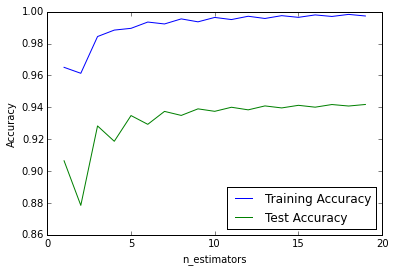

In [56]:
test_random_forest_n_estimators_parameter(range(1,20))

#### Choose max_depth of 16

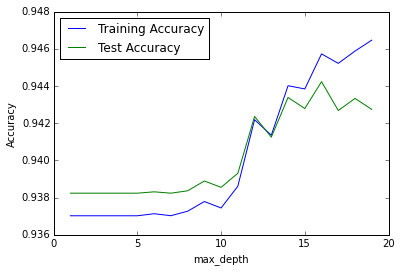

In [79]:
test_random_forest_max_depth_parameter(range(1,20))

#### Choose 4 min samples split

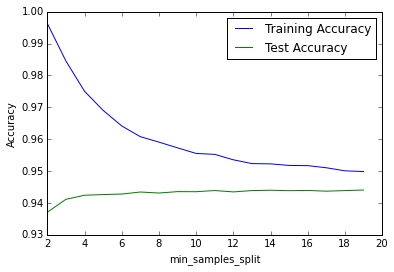

In [80]:
test_random_forest_min_samples_split_parameter(range(2, 20))

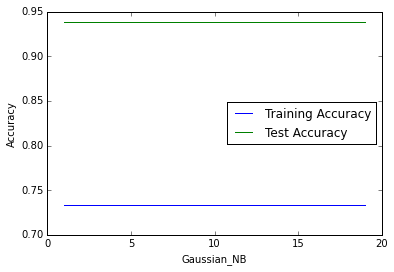

In [22]:
test_Gaussian_NB_estimators()

In [ ]:
test_KNN_test_parameter(range(1, 20))

In [78]:
test_SVM_test_parameter(range(1, 20))

/Users/jkeung/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jkeung/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=12).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jkeung/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=13).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jkeung/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=14).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/jkeung/an

KeyboardInterrupt: 

In [ ]:
# Split the dataset in two equal parts
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.8, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall', 'accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


In [ ]:
1